## Lab 3
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os
import time


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [3]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [4]:
fmnist_dataset_train

Dataset FashionMNIST
    Number of datapoints: 60000
    Split: train
    Root Location: fmnist
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [5]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [6]:
len(fmnist_dataset_test)

10000

In [7]:
len(fmnist_dataset_train)

60000

In [8]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [62]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 200),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.BatchNorm1d(200),
            nn.Linear(200, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [63]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 200]         157,000
              ReLU-3                  [-1, 200]               0
           Dropout-4                  [-1, 200]               0
       BatchNorm1d-5                  [-1, 200]             400
            Linear-6                   [-1, 10]           2,010
Total params: 159,410
Trainable params: 159,410
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.61
Estimated Total Size (MB): 0.62
----------------------------------------------------------------


Your experiments come here:

In [64]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()

In [9]:
def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs: int):
    '''
    model: нейросеть для обучения,
    train_loader, val_loader: загрузчики данных
    loss_fn: целевая метрика (которую будем оптимизировать)
    opt: оптимизатор (обновляет веса нейросети)
    n_epochs: кол-во эпох, полных проходов датасета
    '''
    train_loss = []
    val_loss = []
    val_accuracy = []
    
    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        start_time = time.time()

        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            # move data to target device
            opt.zero_grad()
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            
            prediction = model(X_batch)
            loss = loss_fn(prediction, y_batch)
            loss.backward()
            opt.step()
            

            ep_train_loss.append(loss.item())

        model.train(False) # disable dropout / use averages for batch_norm
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                # move data to target device
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                
                # compute predictions
                prediction = model(X_batch)
                loss = loss_fn(prediction, y_batch)
                
                ep_val_loss.append(loss.item())
                y_pred = prediction.max(1)[1].data
                ep_val_accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy()))

        # print the results for this epoch:
        print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))
        
        print(f"\t  training loss: {train_loss[-1]:.6f}")
        print(f"\tvalidation loss: {val_loss[-1]:.6f}")
        print(f"\tvalidation accuracy: {val_accuracy[-1]:.3f}")

    return train_loss, val_loss, val_accuracy

In [66]:
n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(model, train_loader, test_loader, loss_func, opt, n_epochs)

Epoch 1 of 30 took 3.811s
	  training loss: 0.499164
	validation loss: 0.440168
	validation accuracy: 0.847
Epoch 2 of 30 took 3.762s
	  training loss: 0.405410
	validation loss: 0.408495
	validation accuracy: 0.856
Epoch 3 of 30 took 3.812s
	  training loss: 0.377011
	validation loss: 0.399172
	validation accuracy: 0.859
Epoch 4 of 30 took 3.886s
	  training loss: 0.364486
	validation loss: 0.367968
	validation accuracy: 0.875
Epoch 5 of 30 took 3.752s
	  training loss: 0.351579
	validation loss: 0.373809
	validation accuracy: 0.866
Epoch 6 of 30 took 3.792s
	  training loss: 0.342589
	validation loss: 0.357093
	validation accuracy: 0.873
Epoch 7 of 30 took 3.771s
	  training loss: 0.326878
	validation loss: 0.349167
	validation accuracy: 0.876
Epoch 8 of 30 took 3.793s
	  training loss: 0.319858
	validation loss: 0.342879
	validation accuracy: 0.876
Epoch 9 of 30 took 3.814s
	  training loss: 0.310962
	validation loss: 0.339669
	validation accuracy: 0.879
Epoch 10 of 30 took 3.845s
	

In [10]:
def plot_train_process(train_loss, val_loss, val_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title('Loss')
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].legend()

    axes[1].set_title('Validation accuracy')
    axes[1].plot(val_accuracy)

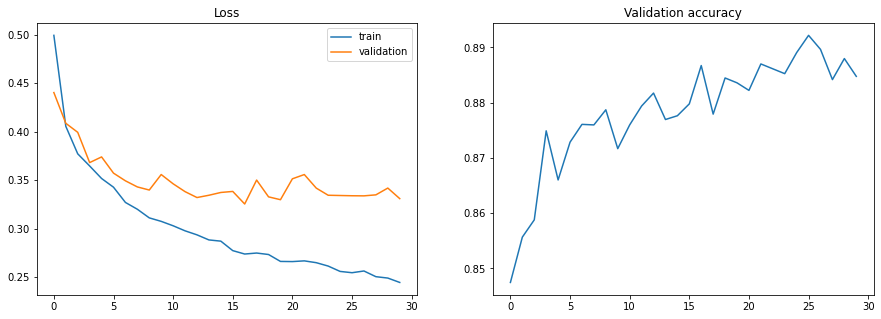

In [68]:
plot_train_process(train_loss, val_loss, val_accuracy)

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [28]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 500),
            nn.ReLU(),
            nn.Linear(500, 200),
            nn.ReLU(),
            nn.Linear(200, 50),
            nn.ReLU(),
            nn.Linear(50, num_classes)
            
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [25]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 500]         392,500
              ReLU-3                  [-1, 500]               0
            Linear-4                  [-1, 200]         100,200
              ReLU-5                  [-1, 200]               0
            Linear-6                   [-1, 50]          10,050
              ReLU-7                   [-1, 50]               0
            Linear-8                   [-1, 10]             510
Total params: 503,260
Trainable params: 503,260
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.92
Estimated Total Size (MB): 1.94
----------------------------------------------------------------


In [29]:
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()

In [30]:
n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(model, train_loader, test_loader, loss_func, opt, n_epochs)

Epoch 1 of 30 took 6.754s
	  training loss: 0.576222
	validation loss: 0.433219
	validation accuracy: 0.842
Epoch 2 of 30 took 6.811s
	  training loss: 0.381293
	validation loss: 0.380602
	validation accuracy: 0.862
Epoch 3 of 30 took 6.399s
	  training loss: 0.339398
	validation loss: 0.383150
	validation accuracy: 0.862
Epoch 4 of 30 took 6.688s
	  training loss: 0.315376
	validation loss: 0.338400
	validation accuracy: 0.877
Epoch 5 of 30 took 6.694s
	  training loss: 0.291403
	validation loss: 0.357450
	validation accuracy: 0.868
Epoch 6 of 30 took 6.408s
	  training loss: 0.278651
	validation loss: 0.344850
	validation accuracy: 0.879
Epoch 7 of 30 took 6.532s
	  training loss: 0.263577
	validation loss: 0.338106
	validation accuracy: 0.877
Epoch 8 of 30 took 6.543s
	  training loss: 0.254176
	validation loss: 0.329475
	validation accuracy: 0.881
Epoch 9 of 30 took 6.253s
	  training loss: 0.241556
	validation loss: 0.334042
	validation accuracy: 0.880
Epoch 10 of 30 took 6.460s
	

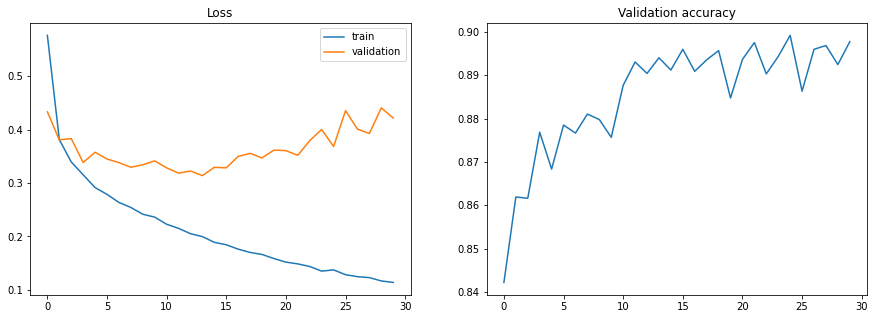

In [31]:
plot_train_process(train_loss, val_loss, val_accuracy)

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [11]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 500),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.BatchNorm1d(500),
            nn.Linear(500, 200),
            nn.ReLU(),
            nn.BatchNorm1d(200),
            # nn.Dropout(p=0.5)
            nn.Linear(200, 50),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.BatchNorm1d(50),
            nn.Linear(50, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [12]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 500]         392,500
              ReLU-3                  [-1, 500]               0
           Dropout-4                  [-1, 500]               0
       BatchNorm1d-5                  [-1, 500]           1,000
            Linear-6                  [-1, 200]         100,200
              ReLU-7                  [-1, 200]               0
       BatchNorm1d-8                  [-1, 200]             400
            Linear-9                   [-1, 50]          10,050
             ReLU-10                   [-1, 50]               0
          Dropout-11                   [-1, 50]               0
      BatchNorm1d-12                   [-1, 50]             100
           Linear-13                   [-1, 10]             510
Total params: 504,760
Trainable params:

In [13]:
model = FixedNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.006)
loss_func = nn.CrossEntropyLoss()

In [14]:
n_epochs = 40

train_loss, val_loss, val_accuracy = train_model(model, train_loader, test_loader, loss_func, opt, n_epochs)

Epoch 1 of 40 took 6.806s
	  training loss: 0.619260
	validation loss: 0.470373
	validation accuracy: 0.827
Epoch 2 of 40 took 7.228s
	  training loss: 0.520833
	validation loss: 0.439277
	validation accuracy: 0.846
Epoch 3 of 40 took 8.239s
	  training loss: 0.491233
	validation loss: 0.442534
	validation accuracy: 0.846
Epoch 4 of 40 took 9.274s
	  training loss: 0.479354
	validation loss: 0.436271
	validation accuracy: 0.851
Epoch 5 of 40 took 8.403s
	  training loss: 0.460410
	validation loss: 0.456843
	validation accuracy: 0.855
Epoch 6 of 40 took 8.448s
	  training loss: 0.447926
	validation loss: 0.400166
	validation accuracy: 0.863
Epoch 7 of 40 took 8.496s
	  training loss: 0.440776
	validation loss: 0.473274
	validation accuracy: 0.854
Epoch 8 of 40 took 8.587s
	  training loss: 0.428593
	validation loss: 0.407374
	validation accuracy: 0.856
Epoch 9 of 40 took 8.698s
	  training loss: 0.431444
	validation loss: 0.453116
	validation accuracy: 0.867
Epoch 10 of 40 took 8.905s
	

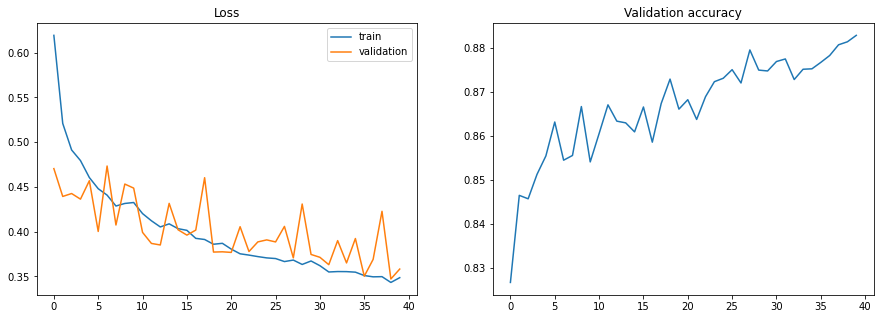

In [15]:
plot_train_process(train_loss, val_loss, val_accuracy)

### Conclusions:
_Write down small report with your conclusions and your ideas._

Первая модель оказалась лучше всего, так как мы имеем всего 60к наблюдений для обучения.

Вторая модель переобучена.

Третья модель имеет 500к параметров, что слишком много для 60к наблюдений, то есть ей не хватает выборки, чтобы обучиться.